# 2D ERT modeling and inversion
## This one tries to copy the deposit shape and do a better image of the geothermal plume


I'll try to add the geothermal plume as a diffusing body, meanwhile I'll keep the plume the same as the simple model.

In [49]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

print(pg.Report())


--------------------------------------------------------------------------------
  Date: Sun Aug 27 20:54:59 2023 -05

                OS : Linux
            CPU(s) : 8
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.6 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32)
  [GCC 12.3.0]

           pygimli : 1.4.3
            pgcore : 1.4.0
             numpy : 1.25.0
        matplotlib : 3.7.2
             scipy : 1.11.2
           IPython : 8.14.0
           pyvista : 0.41.1
--------------------------------------------------------------------------------


## Geometry definition

Create deposit shape

(<Axes: >, None)

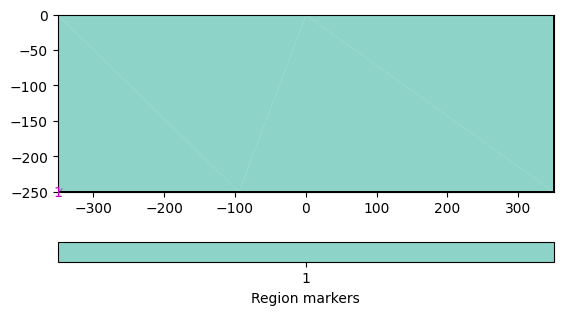

In [50]:
world = mt.createWorld(start=[-350, 0], end=[350, -250], layers=[],
                       worldMarker=True)
pg.show(world)

Calculate fault points position


In [51]:
x1 = -125
y2 = -250

#Find y1 and x2 so fault intersects with first layer base and it has dip = 60°

def f(p):
    x2, y1 = p
    eq1 = y1 - (-150 + 50 * np.sin((x1-300) / 200))
    eq2 = x2 - (x1 + (y2 - y1) / np.tan(np.radians(60)))
    return [eq1, eq2]

from scipy.optimize import fsolve

x2, y1 = fsolve(f, [-100, -200])

Define Floresta Formation

(<Axes: >, None)

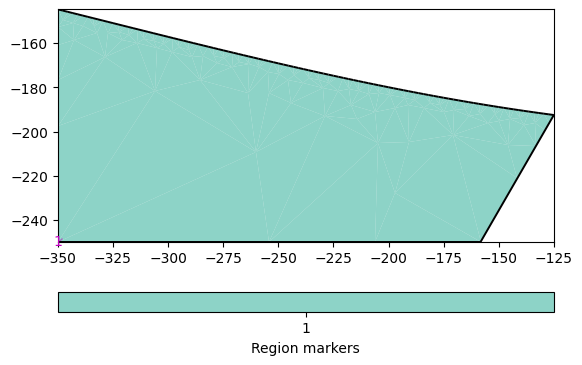

In [52]:
x_top = np.linspace(-350, x1, 100)
y_top = -150 + 50 * np.sin((x_top-300) / 200)

Floresta_top = np.column_stack((x_top,y_top))[::-1]
Floresta_bottom = [[-350, y2], [x2, y2]]
Floresta_verts = np.vstack((Floresta_bottom, Floresta_top))
Floresta_fm = mt.createPolygon(Floresta_verts, isClosed = True, marker = 1)
pg.show(Floresta_fm)

Define Cretacic Rocks

(<Axes: >, None)

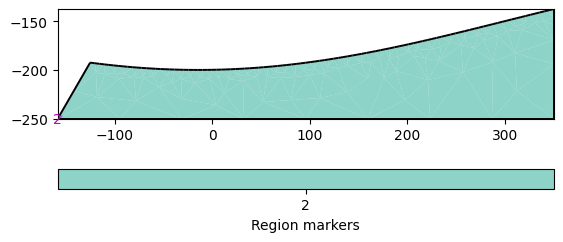

In [53]:
x_top2 = np.linspace(x1, 350, 100)
y_top2 = -150 + 50 * np.sin(((x_top2-300) / 200))

Cretacic_top = np.column_stack((x_top2,y_top2))[::-1]
Cretacic_bottom = [[x2, y2], [350, y2]]
Cretacic_verts = np.vstack((Cretacic_bottom, Cretacic_top))
Cretacic_rocks = mt.createPolygon(Cretacic_verts, isClosed = True, marker = 2)
pg.show(Cretacic_rocks)

Create geothermal plume

In [54]:
plume_verts = np.array([[x1, y1], [-125, -140], [-100, -75], [-60, -60], [-20, -75], [-50, -150]])
plume = mt.createPolygon(plume_verts, isClosed=True, addNodes=10, marker=4)

Create outer plume

Create inner plume

Show Geom

(<Axes: >, None)

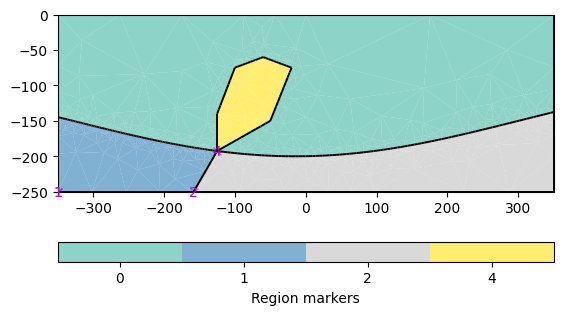

In [55]:
geom = world + Floresta_fm + Cretacic_rocks + plume
pg.show(geom)

## Synthetic data generation
Create a Schlumberger ('slm') measuring scheme with 96 electrodes along a 700m line (-350 to 350)


In [56]:
scheme = ert.createData(elecs=np.linspace(start=-350, stop=350, num=96),
                           schemeName='slm')

Put all electrode (aka sensors) positions into the PLC to enforce mesh
refinement. Due to experience, its convenient to add further refinement
nodes in a distance of 10% of electrode spacing to achieve sufficient
numerical accuracy.



27/08/23 - 20:55:00 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 3 within mesh.
27/08/23 - 20:55:01 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 5 within mesh.


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7fb53411d1e0>)

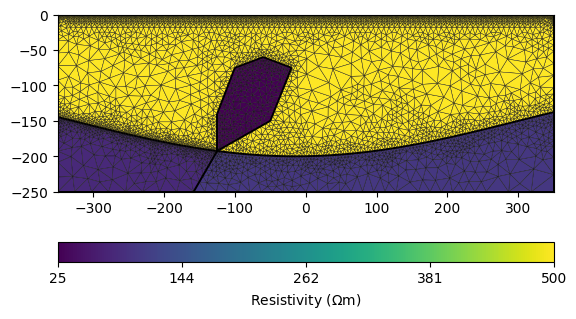

In [57]:
for p in scheme.sensors():
    geom.createNode(p)
    geom.createNode(p - [0, 0.1])

# Create a mesh for the finite element modelling with appropriate mesh quality.
mesh = mt.createMesh(geom, quality=34)

# Define resistivity values for different regions
A = 500.  # Resistivity of siliciclastic rocks (Quartz sandstone, clear, with conglomeratic layers)
B = 80.   # Resistivity of a quaternary aquifer with fresh water
C = 100.   # Resistivity of Limolite and shale
D = 50.    # Resistivity of outer plume
E = 25.    # Resistivity of middle plume
F = 1.     # Resistivity of inner plume

# Create a map to set resistivity values in the appropriate regions
rhomap = [[0, A],
          [1, B],
          [2, C],
          [3, D],
          [4, E],
          [5, F]]

# Take a look at the mesh and the resistivity distribution
pg.show(mesh, data=rhomap, label=pg.unit('res'), showMesh=True)

Perform the modeling with the mesh and the measuring scheme itself
and return a data container with apparent resistivity values,
geometric factors and estimated data errors specified by the noise setting.
The noise is also added to the data. Here 3% plus 1µV.
Note, we force a specific noise seed as we want reproducable results for
testing purposes.



In [58]:
data = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

27/08/23 - 20:55:01 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 3 within mesh.
27/08/23 - 20:55:02 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 5 within mesh.


ModellingBase::setMesh() copying new mesh ... Found datafile: 96 electrodes
Found: 96 free-electrodes
rMin = 3.68421, rMax = 1400
NGauLeg + NGauLag for inverse Fouriertransformation: 15 + 4
Found non-Neumann domain
0.110049 s
FOP updating mesh dependencies ... 2.9e-06 s


27/08/23 - 20:55:04 - pyGIMLi - INFO - 0.4711946745617555 20575.93709431588
27/08/23 - 20:55:04 - pyGIMLi - INFO - Simulated data Data: Sensors: 96 data: 2209, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
27/08/23 - 20:55:04 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
27/08/23 - 20:55:04 - pyGIMLi - INFO - Simulated rhoa (min/max) 292.3178631134466 513.0629271236917
27/08/23 - 20:55:04 - pyGIMLi - INFO - Selected data noise %(min/max) 1.0000092587290836 1.0162042564497076


Calculating response for model: min = 25 max = relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.010000092587290836 : 0.010162042564497075
500
Allocating memory for primary potential...... 0.0437544

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 1.99218s
Response: min = 299.224 max = 500.049 mean = 433.287
Reciprocity rms(modelReciprocity) 1.29507%, max: 6.36667%


Optional: you can filter all values and tokens in the data container.
Its possible that there are some negative data values due to noise and
huge geometric factors. So we need to remove them.



27/08/23 - 20:55:04 - pyGIMLi - INFO - Filtered rhoa (min/max) 292.3178631134466 513.0629271236917


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7fb52fd06d70>)

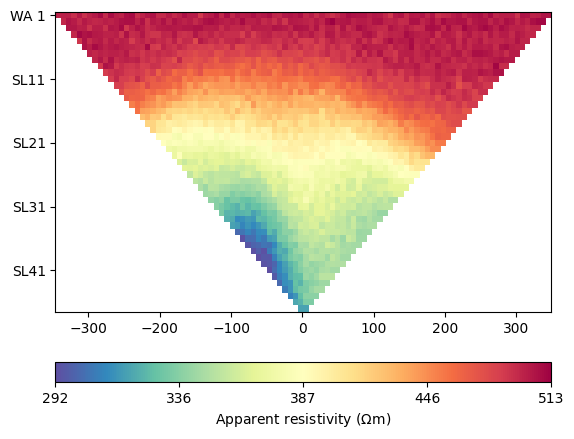

In [59]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('Forward_mod.dat')

# You can take a look at the data
ert.show(data)

## Inversion with the ERTManager
Initialize the ERTManager, e.g. with a data container or a filename.



In [60]:
mgr = ert.ERTManager('Forward_mod.dat')

Run the inversion with the preset data. 
Since I set noise level to 1%, chi^2 target should be close to 0.9 or sighly above, also the regularization parameter should be in the range of 10 to 50 (I chose 30).



In [61]:
inv = mgr.invert(lam=30, verbose=True)
np.testing.assert_approx_equal(mgr.inv.chi2(), 0.9, significant=1)

27/08/23 - 20:55:04 - pyGIMLi - INFO - Found 2 regions.
27/08/23 - 20:55:04 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
27/08/23 - 20:55:04 - pyGIMLi - INFO - Found 2 regions.
27/08/23 - 20:55:04 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
27/08/23 - 20:55:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/08/23 - 20:55:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/08/23 - 20:55:04 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3861 Cells: 7264 Boundaries: 5676
27/08/23 - 20:55:04 - pyGIMLi - INFO - Use median(data values)=449.56855779799
27/08/23 - 20:55:04 - pyGIMLi - INFO - Created startmodel from forward operator: 1519 [449.56855779799,...,449.56855779799]
27/08/23 - 20:55:04 - pyGIMLi - INFO - Starting inversion.


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  1

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  2

Statistics:

  Input vertices: 199
  Input segments: 200
  Input holes: 0

  Mesh vertices: 1023
  Mesh triangles: 1816
  Mesh edges: 2838
  Mesh exterior boundary edges: 228
  Mesh interior boundary edges: 29
  Mesh subsegments (constrained edges): 257

min/max(dweight) = 98.4054/99.9991
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x7fb5346b1b20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x7fb52fef3e20>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x7fb5341127a0>
min/max (data): 2

Let the ERTManger show you the model of the last successful run and how it
fits the data. Shows data, model response, and model.



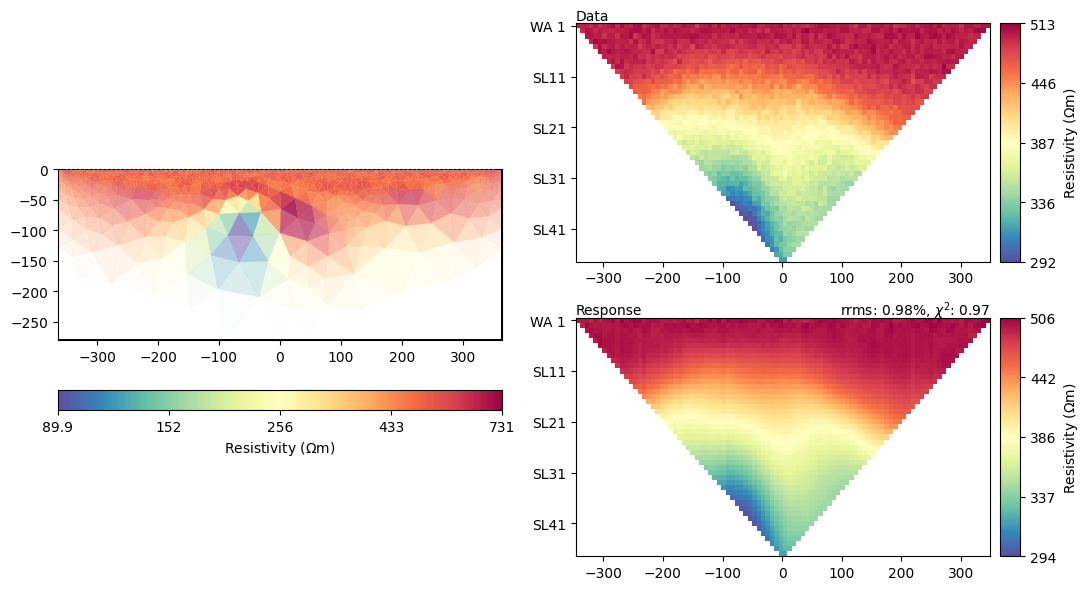

In [62]:
mgr.showResultAndFit()
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later